In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import lightgbm as lgb

In [2]:
# nltk.download('all')
# nltk.download('wordnet')

In [3]:
train_df = pd.read_csv('./Genre Classification Dataset/train_data.txt', sep=':::',engine='python', header=None)
train_df.columns = ['id','title','genre','description']
train_df.head()

,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [4]:
test_df = pd.read_csv('./Genre Classification Dataset/test_data_solution.txt', sep=':::',engine='python', header=None)
test_df.columns = ['id','title','genre','description']
test_df.head()

,id,title,genre,description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


In [5]:
train_df.isnull().sum()

id             0
title          0
genre          0
description    0
dtype: int64

In [8]:
num_classes = len(train_df.genre.unique())

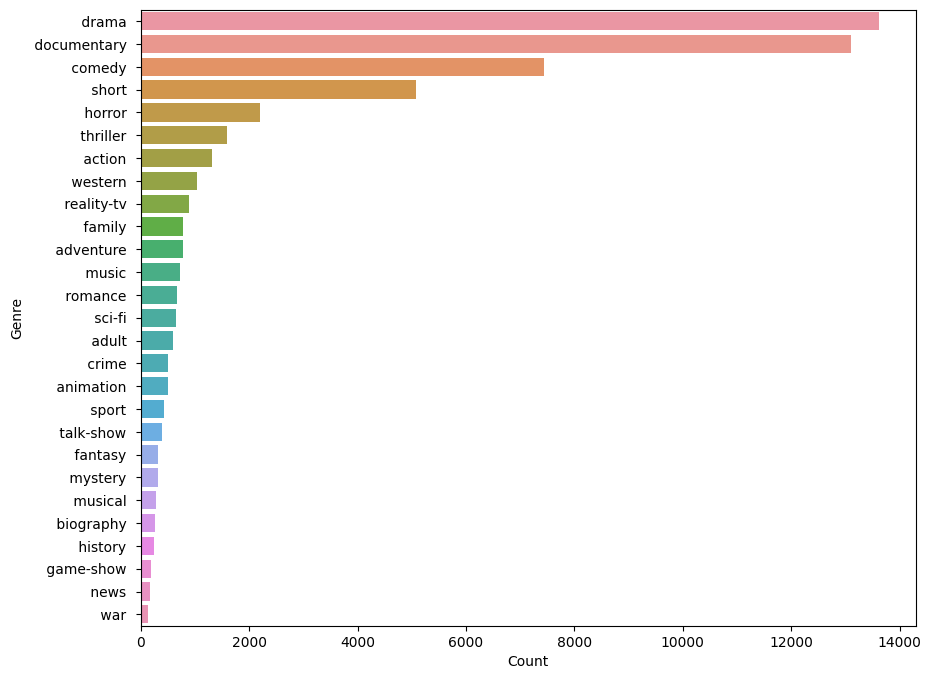

In [7]:
plt.figure(figsize=(10,8))
genreCount = train_df.genre.value_counts()
sns.barplot(x = genreCount, y = genreCount.index)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

In [9]:
genreCount

 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: genre, dtype: int64

In [10]:
train_df['lengthBeforeProcessing'] = train_df.description.apply(len)
train_df.head()

,id,title,genre,description,lengthBeforeProcessing
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625


In [11]:
wordnet_lemmatizer = WordNetLemmatizer()

In [12]:
def text_cleaner(text):
    # lower-case all characters
    text = text.lower()
#     # remove twitter handles
#     text =  re.sub(r'@\S+', '',text)
    # remove urls
    text =  re.sub(r'http\S+', '',text)
    text =  re.sub(r'www\S+', '',text)                  
#     text =  re.sub(r'pic.\S+', '',text) 
    # only keeps characters
    text =  re.sub(r"[^a-zA-Z+]", ' ',text)
    # keep words with length>1 only
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')
    #remove punctuation marks
    text = "".join([i for i in text if i not in string.punctuation])
    #tokenize
    words = nltk.tokenize.word_tokenize(text)
    #lemmatize
    lemmatizedWords = [wordnet_lemmatizer.lemmatize(i) for i in words]
    #remove stop words
    stopwords = nltk.corpus.stopwords.words('english')
    text = " ".join([i for i in lemmatizedWords if i not in stopwords])
    #strip spaces
    text= re.sub("\s[\s]+", " ",text).strip()
    return text

In [14]:
train_df['cleanedDescription'] = train_df.description.apply(text_cleaner)
test_df['cleanedDescription'] = test_df.description.apply(text_cleaner)

In [15]:
train_df['lengthAfterProcessing'] = train_df.cleanedDescription.apply(len)

In [16]:
# from wordcloud import WordCloud
# wordcloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(train_df.description.to_list()))
# # Display the generated Word Cloud
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

In [17]:
train_df.head()

,id,title,genre,description,lengthBeforeProcessing,cleanedDescription,lengthAfterProcessing
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,listening conversation doctor parent year old ...,378
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,brother sister past incestuous relationship cu...,117
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty student field trip museum natural hi...,388
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemployed father make end meet edith twi...,732
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,film title refers un recovered body ground zer...,399


In [18]:
train_df.lengthAfterProcessing.mean()

403.1817242778618

In [19]:
X_train,X_val,y_train,y_val = train_test_split(train_df.cleanedDescription,train_df.genre,test_size=0.1,random_state=42)

In [21]:
X_train.shape, X_val.shape

((48792,), (5422,))

## Support Vector Machine

In [22]:
svc_clf = Pipeline([
        ('vect', CountVectorizer(ngram_range=(1,2))),
        ('tfidf', TfidfTransformer()),
        ('clf', LinearSVC(C=100))
    ])
svc_clf = svc_clf.fit(X_train, y_train)

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [21]:
predicted = svc_clf.predict(X_val)
prediction_acc = np.mean(predicted == y_val)
print("Overall: " + str(prediction_acc*100),"%")

Overall: 60.407636263026845 %


In [23]:
predicted = svc_clf.predict(test_df.cleanedDescription)
prediction_acc = np.mean(predicted == test_df.genre)
print("Overall: " + str(prediction_acc*100),"%")

Overall: 60.47785977859779 %


In [25]:
from joblib import dump, load
dump(svc_clf, './saved_models/svc_clf.joblib')

['./saved_models/svc_clf.joblib']

In [41]:
def get_prediction(text):
    cleanedText = text_cleaner(text)
    ipText = pd.Series([cleanedText])
    pred = svc_clf.predict(ipText)
    return pred[0]

In [42]:
get_prediction("Thor Love and Thunder")

' comedy '

In [26]:
mat = confusion_matrix(y_test, predicted)
plt.figure(figsize=(8, 8))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

NameError: name 'y_test' is not defined

In [86]:
print(metrics.classification_report(y_test, predicted, zero_division=0))

               precision    recall  f1-score   support

      action        0.44      0.37      0.40       253
       adult        0.80      0.46      0.58       120
   adventure        0.71      0.25      0.37       155
   animation        0.47      0.14      0.21       101
   biography        0.00      0.00      0.00        48
      comedy        0.56      0.58      0.57      1474
       crime        0.56      0.04      0.08       112
 documentary        0.69      0.87      0.77      2634
       drama        0.56      0.75      0.64      2726
      family        0.57      0.20      0.29       161
     fantasy        0.10      0.01      0.02        75
   game-show        0.81      0.83      0.82        41
     history        1.00      0.02      0.03        57
      horror        0.56      0.71      0.62       411
       music        0.61      0.60      0.61       136
     musical        0.31      0.06      0.11        63
     mystery        0.33      0.06      0.10        51
        n

## LGBM

In [29]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',
                         learning_rate = 0.1,
                         num_leaves=31, 
                         max_depth=-1, 
                         n_estimators=100, 
                         objective='multiclass', 
                         n_jobs= -1)

In [30]:
lgb_clf = Pipeline([
        ('vect', CountVectorizer(ngram_range = (1,2))),
        ('tfidf', TfidfTransformer()),
        ('clf', clf)
    ])
lgb_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LGBMClassifier(objective='multiclass'))])

In [31]:
predicted = lgb_clf.predict(X_val)
prediction_acc = np.mean(predicted == y_val)
print("Overall: " + str(prediction_acc*100),"%")

Overall: 57.00848395426043 %


In [32]:
predicted = lgb_clf.predict(test_df.cleanedDescription)
prediction_acc = np.mean(predicted == test_df.genre)
print("Overall: " + str(prediction_acc*100),"%")

Overall: 56.84686346863469 %


In [33]:
dump(lgb_clf, './saved_models/lgb_clf.joblib')

['./saved_models/lgb_clf.joblib']

## Deep Learning - Transfer Learning

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [36]:
num_words = 50000
max_len = 200
tokenizer = Tokenizer(num_words=num_words, lower=True)
tokenizer.fit_on_texts(train_df['cleanedDescription'].values)

In [37]:
X_t = tokenizer.texts_to_sequences(X_train.values)
X_t = pad_sequences(X_t, maxlen=max_len)

X_v = tokenizer.texts_to_sequences(X_val.values)
X_v = pad_sequences(X_v, maxlen=max_len)


y_t = pd.get_dummies(y_train).values
y_v = pd.get_dummies(y_val).values

In [38]:
EMBEDDING_DIM = 16
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length=X_t.shape[1]))
model.add(LSTM(100, dropout=0.1))
model.add(Dense(27, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-09-20 01:44:41.666040: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 01:44:41.667856: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array.

In [74]:
X.shape

(43371, 250)